<a href="https://colab.research.google.com/github/wilius47/General-coding-Python-R-/blob/main/Deep%20Learning%20Urban%20extractor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm
from random import shuffle
import torch
from torch import nn
import math
from glob import glob
from os.path import exists
import sys
import shutil
import imageio
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


%matplotlib inline

In [ ]:
# from google.colab import drive
#  drive.mount('/content/drive')

# download data

In [ ]:
filename = "/content/2nd_Dataset.zip"
extract_dir = "./"
archive_format = "zip"

shutil.unpack_archive(filename, extract_dir, archive_format)

# data loader

In [ ]:
import os
import numpy as np
import torch
import torch.utils.data
import torchvision.transforms as transforms
import PIL
import random
from scipy import ndimage


class segDataset(torch.utils.data.Dataset):
    def __init__(self, root, training, transform=None):
        super(segDataset, self).__init__()
        self.root = root
        self.training = training
        self.transform = transform
        self.IMG_NAMES = sorted(glob(self.root + '/*/images/*.jpg'))
        self.BGR_classes = {'Urban' : [0, 0, 0],
                            'Else' : [255,255,255]
                            } # in BGR

        self.bin_classes = ['Urban', 'Else']


    def __getitem__(self, idx):
        img_path = self.IMG_NAMES[idx]
        mask_path = img_path.replace('images', 'masks').replace('.jpg', '.png')

        image = cv2.imread(img_path)
        mask = cv2.imread(mask_path)
        cls_mask = np.zeros(mask.shape)
        cls_mask[mask == self.BGR_classes['Urban']] = self.bin_classes.index('Urban')
        cls_mask[mask == self.BGR_classes['Else']] = self.bin_classes.index('Else')

        cls_mask = cls_mask[:,:,0]

        if self.training==True:
            if self.transform:
              image = transforms.functional.to_pil_image(image)
              image = self.transform(image)
              image = np.array(image)

            # 90 degree rotation
            if np.random.rand()<0.5:
              angle = np.random.randint(4) * 90
              image = ndimage.rotate(image,angle,reshape=True)
              cls_mask = ndimage.rotate(cls_mask,angle,reshape=True)

            # vertical flip
            if np.random.rand()<0.5:
              image = np.flip(image, 0)
              cls_mask = np.flip(cls_mask, 0)

            # horizonal flip
            if np.random.rand()<0.5:
              image = np.flip(image, 1)
              cls_mask = np.flip(cls_mask, 1)

        image = cv2.resize(image, (512,512))/255.0
        cls_mask = cv2.resize(cls_mask, (512,512))
        image = np.moveaxis(image, -1, 0)

        return torch.tensor(image).float(), torch.tensor(cls_mask, dtype=torch.int64)


    def __len__(self):
        return len(self.IMG_NAMES)

In [ ]:
color_shift = transforms.ColorJitter(.1,.1)
blurriness = transforms.GaussianBlur(1, sigma=(0.1, 2.0))

t = transforms.Compose([color_shift, blurriness])
dataset = segDataset('/content/2nd_Dataset', training = True, transform= t)

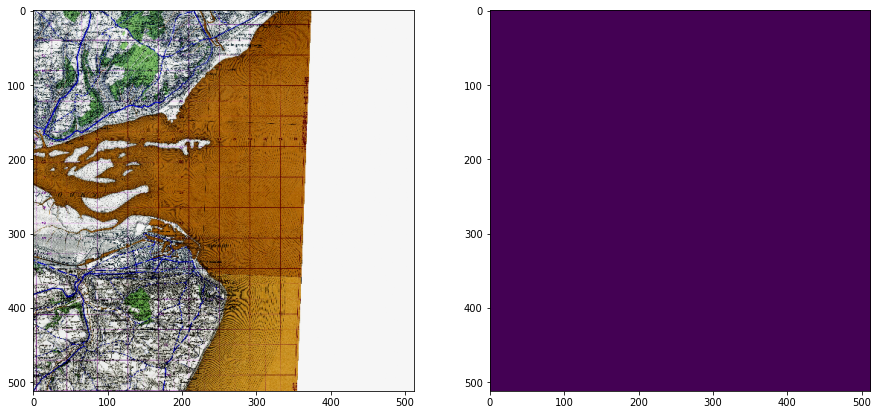

In [ ]:
d = dataset[58]
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(np.moveaxis(d[0].numpy(),0,-1))
plt.subplot(1,2,2)
plt.imshow(d[1].numpy())

In [ ]:
from torch.utils import data

# test_num = int(0.5 * len(dataset))
# print(f'test data : {test_num}')

#https://pytorch.org/docs/stable/data.html

#train_dataset, test_dataset = torch.utils.data.random_split(dataset, [len(dataset)-test_num, test_num], generator=torch.Generator().manual_seed(101))

#train_dataset, test_dataset =torch.utils.data.random_split(dataset, [58,1])
#train_dataset =  dataset[0,57]
#test_dataset =  dataset[58]

# test_dataset  =
# Dataset va devenir ton train_dataser
# test_dataset ?

#print(train_dataset)


#master = data.Dataset( ... )  # your "master" dataset
z = len(dataset)  # how many total elements you have
z_test = int( z - 58 )  # number of test/val elements
z_train = z - 1
idx = list(range(z))  # indices to all elements
train_idx = idx[:z_train]
#val_idx = idx[z_train:(z_train + z_test)]
val_idx = idx[0:58]
test_idx = idx[58:]

train_dataset = data.Subset(dataset, val_idx)
test_dataset = data.Subset(dataset, test_idx)
#val_set = data.Subset(dataset, val_idx)


In [ ]:
BACH_SIZE = 57
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BACH_SIZE, shuffle=True, num_workers=30)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=BACH_SIZE, shuffle=False, num_workers=20)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 30 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# U-net model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [ ]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

# loss

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class FocalLoss(nn.Module):
    def __init__(self, gamma=0, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha,(float,int)): self.alpha = torch.Tensor([alpha,1-alpha])
        if isinstance(alpha,list): self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim()>2:
            input = input.view(input.size(0),input.size(1),-1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1,2)    # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1,input.size(2))   # N,H*W,C => N*H*W,C
        target = target.view(-1,1)

        logpt = F.log_softmax(input, dim=-1)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type()!=input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0,target.data.view(-1))
            logpt = logpt * Variable(at)

        loss = -1 * (1-pt)**self.gamma * logpt
        if self.size_average: return loss.mean()
        else: return loss.sum()

In [ ]:
criterion = FocalLoss(gamma=3/4).to(device)

# Jaccard loss

In [ ]:
class mIoULoss(nn.Module):
    def __init__(self, weight=None, size_average=True, n_classes=2):
        super(mIoULoss, self).__init__()
        self.classes = n_classes

    def to_one_hot(self, tensor):
        n,h,w = tensor.size()
        one_hot = torch.zeros(n,self.classes,h,w).to(tensor.device).scatter_(1,tensor.view(n,1,h,w),1)
        return one_hot

    def forward(self, inputs, target):
        # inputs => N x Classes x H x W
        # target_oneHot => N x Classes x H x W

        N = inputs.size()[0]

        # predicted probabilities for each pixel along channel
        inputs = F.softmax(inputs,dim=1)

        # Numerator Product
        target_oneHot = self.to_one_hot(target)
        inter = inputs * target_oneHot
        ## Sum over all pixels N x C x H x W => N x C
        inter = inter.view(N,self.classes,-1).sum(2)

        #Denominator
        union= inputs + target_oneHot - (inputs*target_oneHot)
        ## Sum over all pixels N x C x H x W => N x C
        union = union.view(N,self.classes,-1).sum(2)

        loss = inter/union

        ## Return average loss over classes and batch
        return 1-loss.mean()

In [ ]:
criterion = mIoULoss(n_classes=6).to(device)

# training

In [ ]:
def acc(label, predicted):
  seg_acc = (y.cpu() == torch.argmax(pred_mask, axis=1).cpu()).sum() / torch.numel(y.cpu())
  return seg_acc

In [ ]:
min_loss = torch.tensor(float('inf'))

model = UNet(n_channels=3, n_classes=6, bilinear=True).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)

In [ ]:
os.makedirs('./saved_models', exist_ok=True)

N_EPOCHS = 35
N_DATA = len(train_dataset)
N_TEST = len(test_dataset)

plot_losses = []
scheduler_counter = 0

for epoch in range(N_EPOCHS):
  # training
  model.train()
  loss_list = []
  acc_list = []
  for batch_i, (x, y) in enumerate(train_dataloader):

      pred_mask = model(x.to(device))
      loss = criterion(pred_mask, y.to(device))

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      loss_list.append(loss.cpu().detach().numpy())
      acc_list.append(acc(y,pred_mask).numpy())

      sys.stdout.write(
          "\r[Epoch %d/%d] [Batch %d/%d] [Loss: %f (%f)]"
          % (
              epoch,
              N_EPOCHS,
              batch_i,
              len(train_dataloader),
              loss.cpu().detach().numpy(),
              np.mean(loss_list),
          )
      )
  scheduler_counter += 1
  # testing
  model.eval()
  val_loss_list = []
  val_acc_list = []
  for batch_i, (x, y) in enumerate(test_dataloader):
      with torch.no_grad():
          pred_mask = model(x.to(device))
      val_loss = criterion(pred_mask, y.to(device))
      val_loss_list.append(val_loss.cpu().detach().numpy())
      val_acc_list.append(acc(y,pred_mask).numpy())

  print(' epoch {} - loss : {:.5f} - acc : {:.2f} - val loss : {:.5f} - val acc : {:.2f}'.format(epoch,
                                                                                                 np.mean(loss_list),
                                                                                                 np.mean(acc_list),
                                                                                                 np.mean(val_loss_list),
                                                                                                 np.mean(val_acc_list)))
  plot_losses.append([epoch, np.mean(loss_list), np.mean(val_loss_list)])

  compare_loss = np.mean(val_loss_list)
  is_best = compare_loss < min_loss
  if is_best == True:
    scheduler_counter = 0
    min_loss = min(compare_loss, min_loss)
    torch.save(model.state_dict(), './saved_models/unet_epoch_{}_{:.5f}.pt'.format(epoch,np.mean(val_loss_list)))

  if scheduler_counter > 5:
    lr_scheduler.step()
    print(f"lowering learning rate to {optimizer.param_groups[0]['lr']}")
    scheduler_counter = 0


OutOfMemoryError: ignored

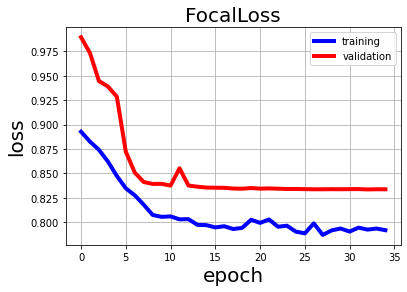

In [ ]:
# plot loss
plot_losses = np.array(plot_losses)
plt.plot(plot_losses[:,0], plot_losses[:,1], color='b', linewidth=4)
plt.plot(plot_losses[:,0], plot_losses[:,2], color='r', linewidth=4)
plt.title('FocalLoss', fontsize=20)
plt.xlabel('epoch',fontsize=20)
plt.ylabel('loss',fontsize=20)
plt.grid()
plt.legend(['training', 'validation']) # using a named size
plt.show()

# testing

In [ ]:
model.eval()

for batch_i, (x, y) in enumerate(test_dataloader):
    for j in range(len(x)):
        result = model(x.to(device)[j:j+1])
        mask = torch.argmax(result, axis=1).cpu().detach().numpy()[0]
        im = Image.fromarray((mask * 255).astype(np.uint8))
        im.save("/content/test_"+str(j)+".tif")





NameError: ignored

In [ ]:
model.load_state_dict(torch.load('/content/saved_models/unet_epoch_44_0.77706.pt'))

RuntimeError: ignored

In [ ]:
model.eval()

for batch_i, (x, y) in enumerate(test_dataloader):
    for j in range(len(x)):
        result = model(x.to(device)[j:j+1])
        mask = torch.argmax(result, axis=1).cpu().detach().numpy()[0]
        im = np.moveaxis(x.to(device)[j].cpu().detach().numpy(), 0, -1).copy()*255
        im = im.astype(int)
        gt_mask = y[j]

        plt.figure(figsize=(300,300))

        plt.subplot(1,3,1)
        im = np.moveaxis(x.to(device)[j].cpu().detach().numpy(), 0, -1).copy()*255
        im = im.astype(int)
        plt.imshow(im)

        plt.subplot(1,3,2)
        plt.imshow(gt_mask)

        im = Image.fromarray((mask * 255).astype(np.uint8))
        im.save("/content/mask.tif")

        plt.subplot(1,3,3)
        plt.imshow(mask)
        plt.show()

NameError: ignored

In [ ]:
# ! rm -r /content/saved_models

In [ ]:
 #test = torch.rand(1,3,256,256).to(device)

In [ ]:
 #model(test).shape

In [ ]:
 #test_img = cv2.imread('/content/SC50_HISTO1950_0475_6945_L93_E100.jp2')
 #test_img = cv2.resize(test_img, (256,256))/255.0)
#test_img = np.moveaxis(test_img, -1, 0).reshape(-1,3,256,256)
 #test_img = torch.tensor(test_img).float()
 #test_img
 #print (test_img)

# Predicting urbanisation


In [ ]:
#print("Generate a prediction")
#prediction = model.predict(x_test[:1])
#print("prediction shape:", prediction.shape)



In [ ]:
BACH_SIZE2 = 1
#train_dataloader = torch.utils.data.DataLoader(
    #train_dataset, batch_size=BACH_SIZE, shuffle=True, num_workers=20)
img_path = '/content/SC50_HISTO1950_0475_6945_L93_E100.jp2'
Scanhisto = cv2.imread(img_path)
print(Scanhisto)
#test_dataset2 = ('/content/2nd_Dataset', training = True, transform= t)
test_dataloader2 = torch.utils.data.DataLoader(
    Scanhisto, batch_size=BACH_SIZE2, shuffle=False, num_workers=2)
#prediction = model.predict(test_dataloader2)

None




```
# Ce texte est au format code
```

# Training using the repository

In [ ]:
# download data

# !gdown https://drive.google.com/u/0/uc?id=1uJDMDv0bRqu30_b6kEGZjW0S4Sr6TBOi&export=download

# filename = "./Semantic segmentation of aerial imagery.zip"
# extract_dir = "./"
# archive_format = "zip"

# shutil.unpack_archive(filename, extract_dir, archive_format)

In [ ]:
!git clone https://github.com/amirhosseinh77/UNet-AerialSegmentation

Cloning into 'UNet-AerialSegmentation'...
remote: Enumerating objects: 77, done.
remote: Counting objects: 100% (77/77), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 77 (delta 43), reused 33 (delta 15), pack-reused 0
Unpacking objects: 100% (77/77), done.


In [ ]:
#torch.cuda.memory_summary(device=None, abbreviated=False)
#torch.cuda.empty_cache()
#!pip install GPUtil

#from GPUtil import showUtilization as gpu_usage
#from numba import cuda
#cuda.select_device(0)
#cuda.close()
#cuda.select_device(0)
#gpu_usage()
